# Imports

In [1]:
# File R/W
import os

# Additional Inbuilt Utilities
import itertools
import functools

# Regex
import re

# Array
import numpy as np

# Table
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Advanced Computations
import scipy as sc

# Statistics
import statsmodels.api as sm

# Neurophysiological Data Analysis
import mne
import mne_nirs # esp. for fNIRS

# Neuroimaging Statistical Tools
import nilearn

# Vistual Display
from pyvirtualdisplay import Display

In [2]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

# Custom Settings
%aimport constants

# Custom Functions
%aimport utils

# Modified MBLL
%aimport mbll

# Custom Class
%aimport nirs
NIRS = nirs.NIRS

## Config

In [3]:
mne.set_log_level('WARNING')

In [4]:
# Set plotting backend for MNE
mne.viz.set_browser_backend('matplotlib') # qt, matplotlib
mne.viz.set_3d_backend('notebook') # pyvistaqt, notebook

# MAIN

In [5]:
# Instantiate NIRS() and read data
nirs = NIRS().read(1, 2, 3, transform=False)

/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:398: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  self.raw.set_annotations(mne.Annotations(


In [6]:
# Pre-process the data using the default pipeline, with dpf/ppf as argument (default `constants.PPF`)
# Output is a dictionary of intermediate mne.Raw instances
# Stages: CW     (raw signal)
#         CWx    (backlight removed raw signal)
#         OD     (optical density)
#         TDD    (motion artifact removal)
#         SSR    (short-channel regression)
#         HB     (chromophore/haemoglobin)
#         FL     (bandpass filtering)
#         NCE    (negative correlation improvement)
savepoints = nirs.default_pipeline(remove_backlight=False, tddr=False, short_channel_regression=False, bandpass=True, negative_correlation_enhancement=False, ppf=0.1)

/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:480: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  return func(self.raw, *args, **kwargs)


---

In [7]:
raw_haemo = nirs.raw.copy()

<AxesSubplot: xlabel='Condition', ylabel='Theta'>

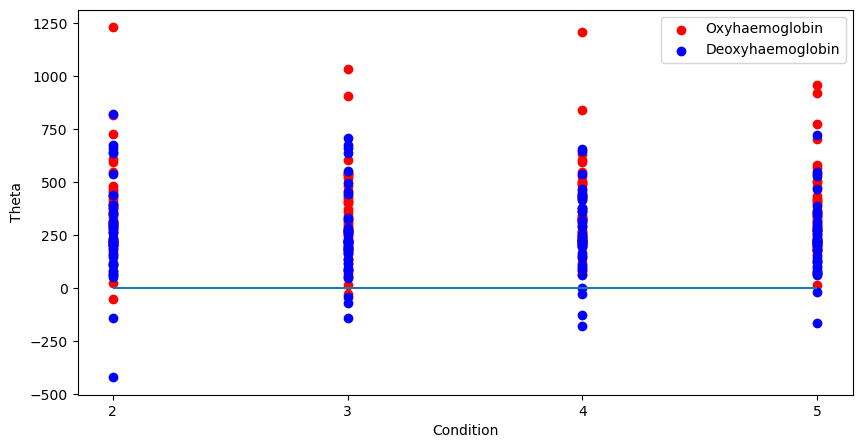

In [8]:
design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo, drift_model=None, hrf_model='spm',
                                                                            # high_pass=1/2/(nirs.DUR['trial']),
                                                                            stim_dur=nirs.DUR['motion'])

# design_matrix["ShortHbO"] = np.mean(short_chs.copy().pick(picks="hbo").get_data(), axis=0)
# design_matrix["ShortHbR"] = np.mean(short_chs.copy().pick(picks="hbr").get_data(), axis=0)

glm_est = mne_nirs.statistics.run_glm(raw_haemo, design_matrix)

glm_est.scatter()

---

`Without any preprocessing steps`

In [9]:
# Pre-process

raw_intensity = savepoints['CW'].copy()
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
short_chs = mne_nirs.channels.get_short_channels(raw_haemo)
raw_haemo = mne_nirs.channels.get_long_channels(raw_haemo)

# raw_haemo = nirs.raw.copy()
# short_chs = nirs.short_channels

/tmp/ipykernel_932786/3014415978.py:4: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


In [10]:
# Create design matrix

design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo, drift_model=None, hrf_model='spm',
                                                                            # high_pass=1/2/(nirs.DUR['trial']),
                                                                            stim_dur=nirs.DUR['motion'])

In [11]:
# Run GLM analysis on all data

glm_est = mne_nirs.statistics.run_glm(raw_haemo, design_matrix)

<AxesSubplot: xlabel='Condition', ylabel='Theta'>

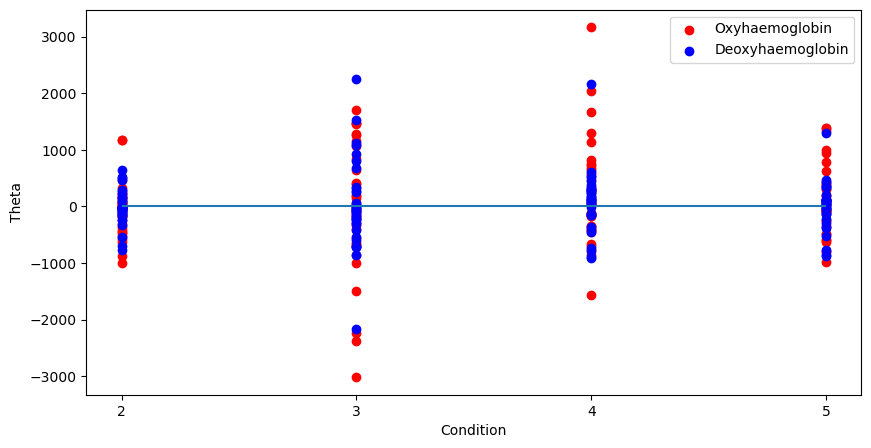

In [12]:
# Visualize regression coefficients for all channels

glm_est.scatter()